In [1]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split 

import pandas
import numpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import xgboost as xgb

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.python.keras import layers
from tensorflow.python.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.python.keras.models import Model
from keras.utils import plot_model

import seaborn as sns
import os
import tempfile
from imblearn.over_sampling import SMOTE

scaler = StandardScaler()
oversample = SMOTE()

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
df = pandas.read_csv('../colo_data_mar22_d032222.csv')

In [4]:
df = df[[

    'age',
    'sex',
    
    'race7',
    'educat',
    'marital',
    'occupat',

    'cig_stat',
    'cig_years',
    'cigpd_f',
    'cigar',
    'pipe',

    'fh_cancer',
    'colo_fh',
    'colo_fh_cnt',

    'bmi_curr',

    'asp',
    'asppd',
    'ibup',
    'ibuppd',
    
    'arthrit_f',
    'bronchit_f',
    'colon_comorbidity',
    'diabetes_f',
    'divertic_f',
    'emphys_f',
    'gallblad_f',
    'hearta_f',
    'hyperten_f',
    'liver_comorbidity',
    'osteopor_f',
    'polyps_f',
    'stroke_f',

    'colo_cancer'

]]

In [5]:
# filling null values
for column in df:

    # raw numeric features
    if (column == 'age' or column == 'bmi_curr' or column == 'cig_years'): 
        df[column] = df[column].fillna(df[column].mean())
        
    # default siblings to 0 (average is 0.11)
    elif (column == 'colo_fh_cnt'): 
        df[column] = df[column].fillna(0)
       
    # rest are categorized  
    else: df[column] = df[column].fillna(df[column].mode()[0])

df.isnull().sum()

age                  0
sex                  0
race7                0
educat               0
marital              0
occupat              0
cig_stat             0
cig_years            0
cigpd_f              0
cigar                0
pipe                 0
fh_cancer            0
colo_fh              0
colo_fh_cnt          0
bmi_curr             0
asp                  0
asppd                0
ibup                 0
ibuppd               0
arthrit_f            0
bronchit_f           0
colon_comorbidity    0
diabetes_f           0
divertic_f           0
emphys_f             0
gallblad_f           0
hearta_f             0
hyperten_f           0
liver_comorbidity    0
osteopor_f           0
polyps_f             0
stroke_f             0
colo_cancer          0
dtype: int64

In [6]:
y = df['colo_cancer']
X = df.drop('colo_cancer', axis = 1)

In [7]:
neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

X, y = oversample.fit_resample(X, y)

neg, pos = numpy.bincount(y)
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 154887
    Positive: 2359 (1.52% of total)


Examples:
    Total: 305056
    Positive: 152528 (50.00% of total)



In [8]:
train_features, test_features, train_labels, test_labels = train_test_split(X, y, test_size = 0.2, random_state = 42)
train_features, val_features, train_labels, val_labels = train_test_split(train_features, train_labels, test_size = 0.25, random_state = 42)

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (183033,)
Validation labels shape: (61011,)
Test labels shape: (61012,)
Training features shape: (183033, 32)
Validation features shape: (61011, 32)
Test features shape: (61012, 32)


In [ ]:
pos_df = pandas.DataFrame(train_features[ bool_train_labels], columns=train_df.columns)
neg_df = pandas.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

In [9]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR') # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None: output_bias = tf.keras.initializers.Constant(output_bias)

  model = keras.Sequential([
    keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1],)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias),
  ])

  model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=metrics)

  return model

In [10]:
EPOCHS = 100
BATCH_SIZE = 32

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 545
Trainable params: 545
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.predict(train_features[:10])

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_bias = numpy.log([pos/neg])
initial_bias

In [ ]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

In [ ]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE)
print("Loss: {:0.4f}".format(results[0]))

In [ ]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
print(initial_weights)
model.save_weights(initial_weights)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [12]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

In [ ]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [13]:
model = make_model()
# model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
5720/5720 [==============================] - 11s 2ms/step - loss: 0.6392 - tp: 65279.0000 - fp: 38914.0000 - tn: 52559.0000 - fn: 26281.0000 - accuracy: 0.6438 - precision: 0.6265 - recall: 0.7130 - auc: 0.6903 - prc: 0.6502 - val_loss: 0.5897 - val_tp: 22047.0000 - val_fp: 9972.0000 - val_tn: 20593.0000 - val_fn: 8399.0000 - val_accuracy: 0.6989 - val_precision: 0.6886 - val_recall: 0.7241 - val_auc: 0.7611 - val_prc: 0.7374
Epoch 2/100
5720/5720 [==============================] - 10s 2ms/step - loss: 0.6030 - tp: 67372.0000 - fp: 35036.0000 - tn: 56437.0000 - fn: 24188.0000 - accuracy: 0.6764 - precision: 0.6579 - recall: 0.7358 - auc: 0.7368 - prc: 0.7086 - val_loss: 0.5692 - val_tp: 22859.0000 - val_fp: 9744.0000 - val_tn: 20821.0000 - val_fn: 7587.0000 - val_accuracy: 0.7159 - val_precision: 0.7011 - val_recall: 0.7508 - val_auc: 0.7866 - val_prc: 0.7647
Epoch 3/100
5720/5720 [==============================] - 11s 2ms/step - loss: 0.5931 - tp: 67890.0000 - fp: 34062.00

In [14]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

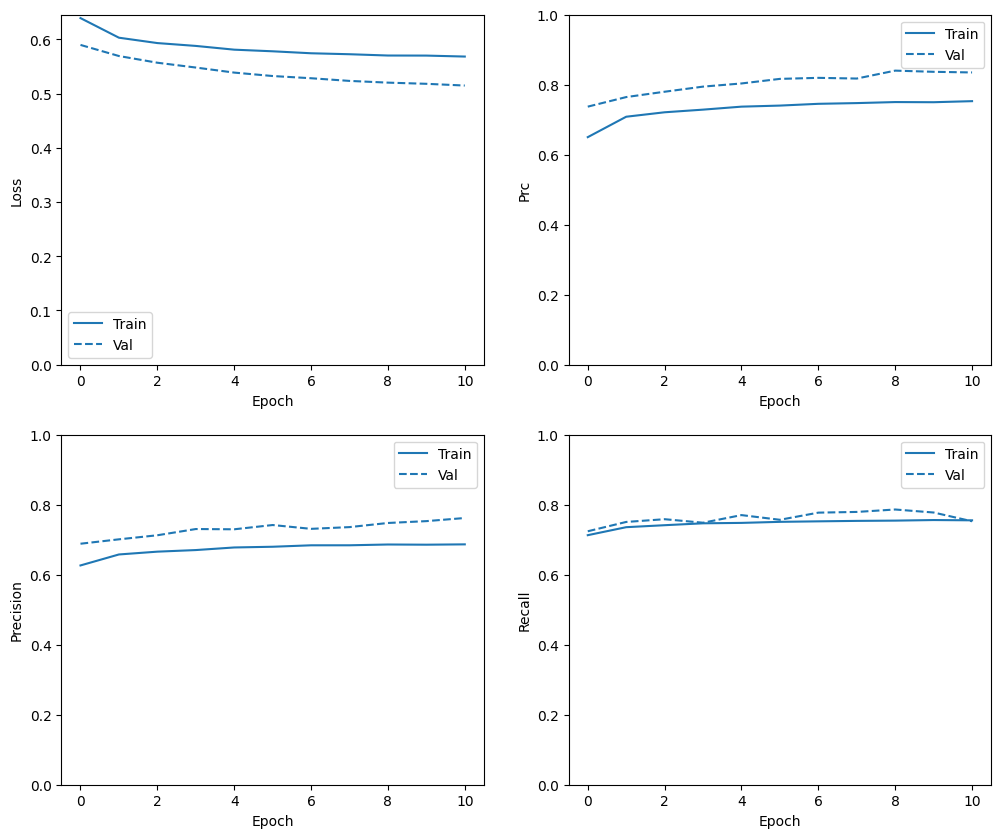

In [15]:
plot_metrics(baseline_history)

In [16]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

1907/1907 [==============================] - 2s 1ms/step


In [17]:
def plot_cm(labels, predictions, p=0.5):
  cm = metrics.confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('No Cancer Detected (True Negatives): ', cm[0][0])
  print('No Cancer Missed (False Positives): ', cm[0][1])
  print('Cancer Missed (False Negatives): ', cm[1][0])
  print('Cancer Detected (True Positives): ', cm[1][1])
  print('Total Cancer Cases: ', numpy.sum(cm[1]))

loss :  0.5895892977714539
tp :  21877.0
fp :  9793.0
tn :  20697.0
fn :  8645.0
accuracy :  0.6977971792221069
precision :  0.6907799243927002
recall :  0.7167617082595825
auc :  0.7621607780456543
prc :  0.741907000541687

No Cancer Detected (True Negatives):  20697
No Cancer Missed (False Positives):  9793
Cancer Missed (False Negatives):  8645
Cancer Detected (True Positives):  21877
Total Cancer Cases:  30522


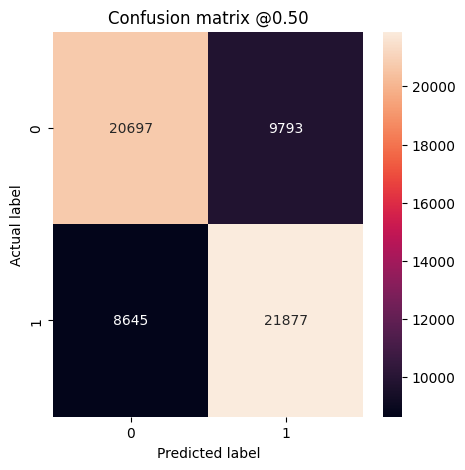

In [18]:
baseline_results = model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [32]:
def plot_roc(name, labels, predictions, **kwargs):
  fp, tp, _ = metrics.roc_curve(labels, predictions)

  plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([0,100])
  plt.ylim([0,100])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

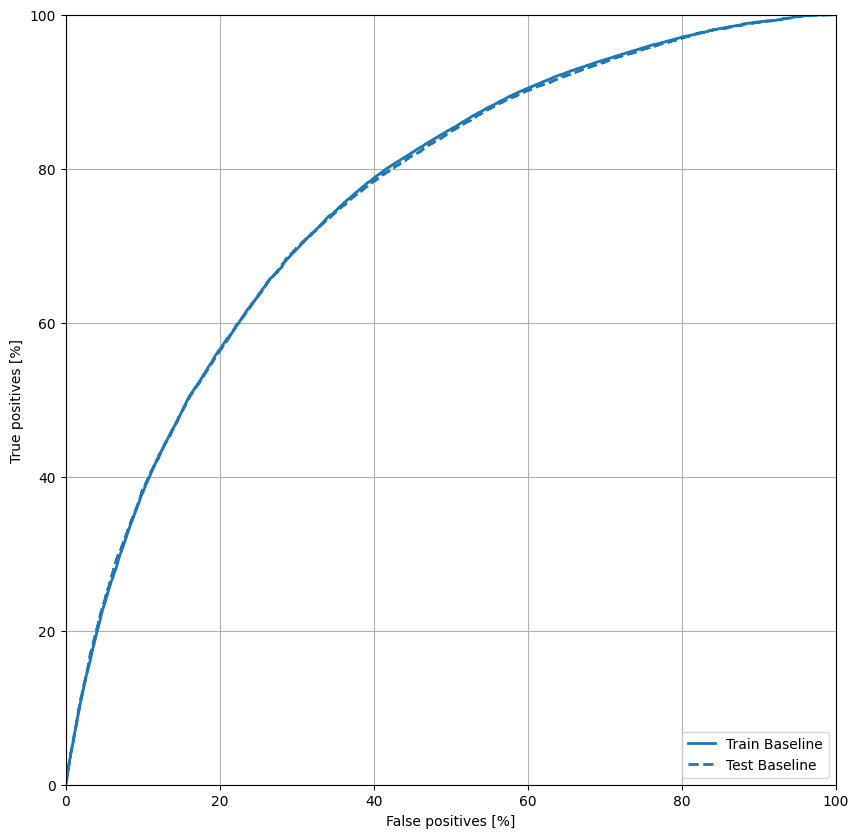

In [33]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [34]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

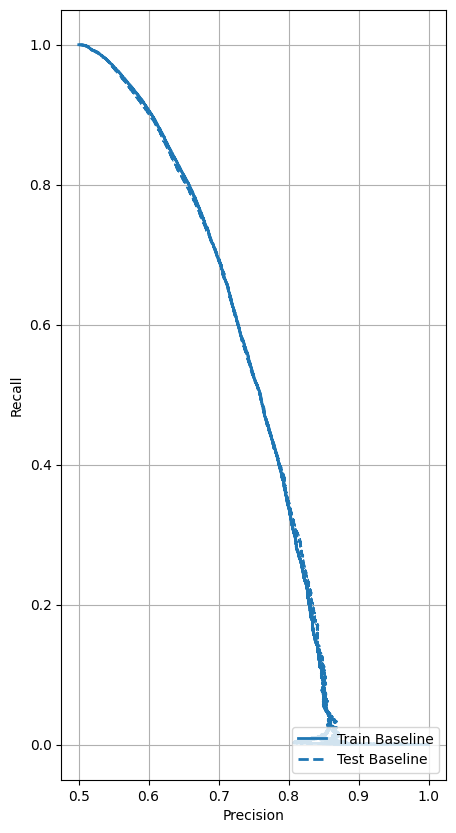

In [35]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

'''class_weight = {0: weight_for_0, 1: weight_for_1}'''
class_weight = {0: 2, 1: 45}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

In [ ]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

In [ ]:
plot_metrics(weighted_history)

In [ ]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
weighted_results = weighted_model.evaluate(test_features, test_labels, batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plt.legend(loc='lower right');

In [ ]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

print(pos_features.shape)
print()
print(neg_features.shape)
print()
print(pos_labels.shape)
print()
print(neg_labels.shape)

In [ ]:
ids = numpy.arange(len(pos_features))
choices = numpy.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

In [ ]:
resampled_features = numpy.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = numpy.concatenate([res_pos_labels, neg_labels], axis=0)

order = numpy.arange(len(resampled_labels))
numpy.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

In [ ]:
resampled_steps_per_epoch = numpy.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_features,
    resampled_labels,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    # resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=()) # val_ds

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [ ]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right');